### Import Libraries

In [2]:
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
import warnings

In [3]:
# Suppress all warnings
warnings.filterwarnings("ignore")

### Data Collection

Set date as the index of the DataFrame and sort index in ascending order

In [4]:
# read excel file and store as df
df = pd.read_excel('S&P500.xlsx').drop(columns=['Adj Close']).set_index('Date').sort_index(ascending=True)

# set freq
freq = pd.infer_freq(df.index)

# set target
target = 'Close'

df

,Open,High,Low,Close,Volume
Date,,,,,
1985-01-01,167.20,180.27,163.36,179.63,2673710000
1985-02-01,179.63,183.95,177.75,181.18,2194620000
1985-03-01,181.18,183.89,176.53,180.66,2153090000
1985-04-01,180.66,183.61,177.86,179.83,1981880000
1985-05-01,179.83,189.98,178.35,189.55,2350340000
...,...,...,...,...,...
2023-06-01,4183.03,4458.48,4171.64,4450.38,87983140000
2023-07-01,4450.48,4607.07,4385.05,4588.96,75063200000
2023-08-01,4578.83,4584.62,4335.31,4507.66,86840820000


### Seasonal Decomposition 

##### Is there Seasonality in the Time Series? What is the best m?

- The seasonal period/order (m) is likely the lag position where autocorrelation or partial autocorrelation sharply decreases, signaling the presence of a seasonal pattern in the data.

- If the ACF and PACF suggest different values for m, it could imply that the seasonality in the time series is not straightforward or does not strictly follow a single pattern.

- If one plot indicates a value for m, while the other does not, it may suggest the presence of more complex temporal patterns, possibly involving multiple seasonal components or a combination of trends.

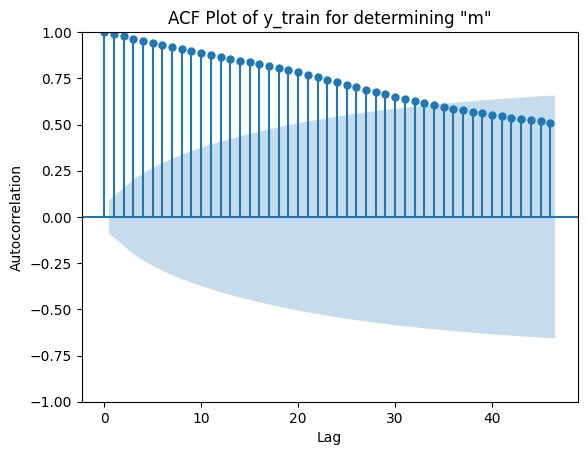

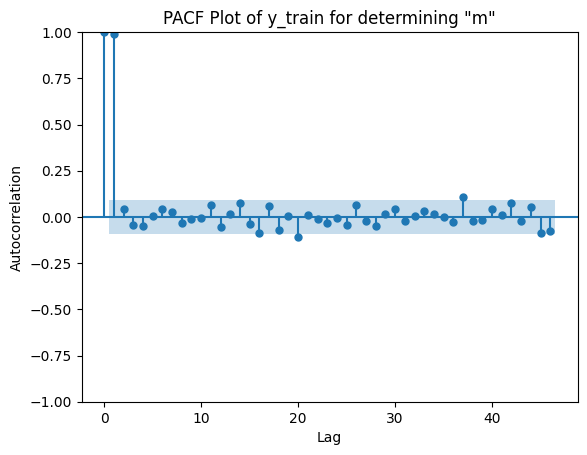

In [5]:
def find_best_m(series):
     
    # Plot ACF using the plot_acf function on undifferenced y_train
    plot_acf(series, lags=int(0.1 * len(series)))
    plt.title('ACF Plot of y_train for determining "m"')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    # Plot PACF using the plot_acf function on undifferenced y_train
    plot_pacf(series, lags=int(0.1 * len(series)))
    plt.title('PACF Plot of y_train for determining "m"')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()
    

# Call the function with your y_train data
find_best_m(df[target])

In [6]:
# Set value 
# m=1 means no seasonality
# do not set m=0 as its not meaningful
# set m=x for any identified seasonality
m = 1 

print(f"Estimated m: {m}")

Estimated m: 1


##### Auto Seasonal Decomposition

Selected Model: additive
Selected Period: 1


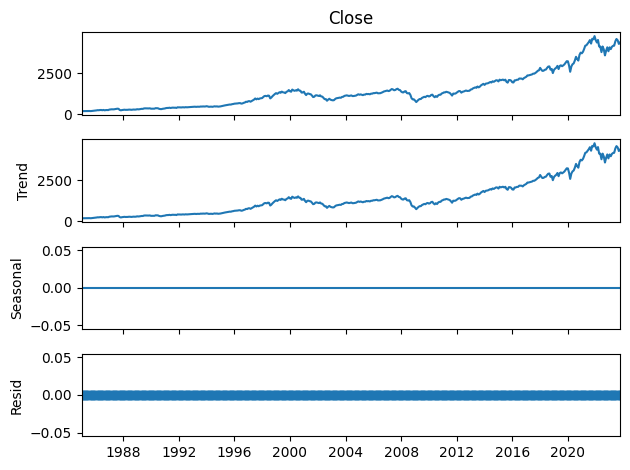

In [8]:
# Function to automate decomposition model and seasonality period selection
def auto_decompose(series):
    # Perform ADF test for stationarity
    result_adf = adfuller(series)
    is_stationary = result_adf[1] < 0.05  # Check if p-value is less than 0.05

    # Choose decomposition model based on stationarity
    selected_model = 'multiplicative' if is_stationary else 'additive'

    # retrieve selected period
    selected_period = m
    
    print(f"Selected Model: {selected_model}")
    print(f"Selected Period: {selected_period}")

    return selected_model , selected_period

# Perform automated decomposition model and seasonality period selection
selected_model, selected_period = auto_decompose(df[target])

# Perform seasonal decomposition with the selected model and period
result = seasonal_decompose(df[target], model=selected_model, period=selected_period)

# Plot the decomposed components
result.plot()
plt.show()

### Feature Engineering

In [9]:
def extract_calendar_features(dataframe):
    
    # Extract calendar features from the index
    dataframe['year'] = dataframe.index.year
    dataframe['month'] = dataframe.index.month
    dataframe['day'] = dataframe.index.day
    dataframe['day_of_week'] = dataframe.index.dayofweek  # Monday is 0 and Sunday is 6
    dataframe['day_of_year'] = dataframe.index.dayofyear
    dataframe['week_of_year'] = dataframe.index.isocalendar().week

    return dataframe

# Create calendar features for the DataFrame with a datetime index
df = extract_calendar_features(df)

In [10]:
def extract_lag_features(dataframe, target, num_lags):

    for lag in range(1, num_lags + 1):
        dataframe[f"lag_{lag}"] = dataframe[target].shift(lag)
        
    dataframe = dataframe.dropna()

    return dataframe

# Add lag features for the 'target_column' with n lags
df = extract_lag_features(df, target, num_lags=3)

### Data Split

In [11]:
X = df[[item for item in df.columns if item != target]]
y = df[target]

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, random_state=42, shuffle=False)

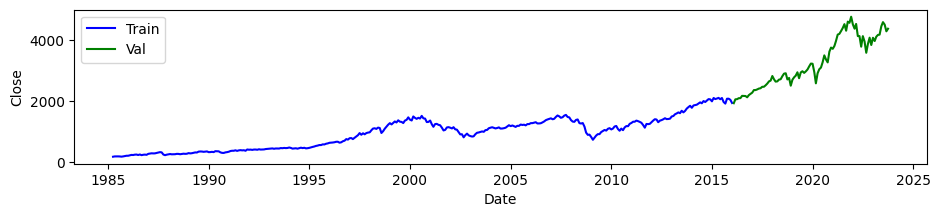

In [13]:
# Plot Train-Val Set
plt.figure(figsize=(11,2))
sns.lineplot(y_train, label = 'Train', color = 'blue')
sns.lineplot(y_val, label = 'Val', color = 'green')
plt.legend()
plt.show()

### Time Series Modeling with Advanced Regressors (with External Variables)

##### Identyfying Feature Types

In [14]:
# Assuming you have lists of numerical and categorical column names
numerical_cols = df.select_dtypes(include=[int, float]).columns.to_list()
categorical_cols = df.select_dtypes(include=[object]).columns.to_list()

# Removing the target from numerical & categorical columns
numerical_cols = [col for col in numerical_cols if target not in col]
categorical_cols = [col for col in categorical_cols if target not in col]

##### Handling Numerical and Categorical Features

In [15]:
# Handling numerical variables with StandardScaler
if numerical_cols:
    std_scaler = StandardScaler()
    X_train_numerical = std_scaler.fit_transform(X_train[numerical_cols])
    X_val_numerical = std_scaler.transform(X_val[numerical_cols])

# Handling categorical variables with Label Encoding
if categorical_cols:
    label_encoder = LabelEncoder()
    X_train_categorical = label_encoder.fit_transform(X_train[categorical_cols])
    X_val_categorical = label_encoder.transform(X_val[categorical_cols])

##### Concatenate Numerical and Categorical features

In [16]:
# Concatenating processed numerical and categorical data if both exist
if numerical_cols and categorical_cols:
    X_train_processed = np.hstack([X_train_numerical, X_train_categorical])
    X_val_processed = np.hstack([X_val_numerical, X_val_categorical])
else:
    # Renaming if either numerical or categorical array is missing
    X_train = X_train_numerical if numerical_cols else X_train_categorical
    X_val = X_val_numerical if numerical_cols else X_val_categorical